In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7239d481-366e-b439-cd3b-6e3d419ad97c)


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 5.90 MiB/s, done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
import os

paths_to_files = [data_dir + file_name for file_name in os.listdir(data_dir)]

paths_to_files

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [7]:
def getlines(filename) -> list:
  """
  Reads filename (a text file name) and returns the lines of text as a list
  
  Args:
    filename: a string containing the target filepath

  Returns:
    a list of strings with one string per line from the target filename.
  """

  with open(filename,'r') as f:
    return f.readlines()




In [8]:
train_lines = getlines(data_dir + 'train.txt')

train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

In [10]:
[{'line_number':0,
  'target':'BACKGROUND',
  'text':'Emotional eating is associated with overeating and the development of obesity .\n',
  'total_lines':11},
 ]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
  'total_lines': 11}]

In [11]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.
  Takes in filename, reads it contents and sorts through each line,
  extracting thngs like the target label, the text of sentence, 
  how many sentences there are in the current abstract and 
  what sentence number the target line is.
  """

  input_lines = getlines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) -1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [12]:
%%time

train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
validate_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')

print(len(train_samples), len(test_samples), len(validate_samples))

180040 30135 30212
CPU times: user 585 ms, sys: 101 ms, total: 686 ms
Wall time: 759 ms


In [13]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(validate_samples)

In [14]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [15]:
train_sentences = train_df['text'].to_list()
test_sentences = test_df['text'].to_list()
validate_sentences = val_df['text'].to_list()

train_sentences [:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [16]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot.transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot.transform(val_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())

train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [18]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline model

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [20]:
model_0 = Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])


model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
model_0.score(X = validate_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [22]:
model_0_preds = model_0.predict(validate_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-02-14 02:40:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-14 02:40:42 (99.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
import helper_functions as hf

In [25]:
model_0_results = hf.calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_0_preds)

model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers



In [27]:
# Check how long is each sentence on average

sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)

avg_sent_len

26.338269273494777

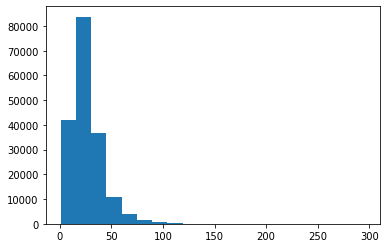

In [28]:
from matplotlib import pyplot as plt

plt.hist(sent_len, bins = 20);

In [29]:
output_sent_len = int(np.percentile(sent_len,95))
output_sent_len

55

In [30]:
max_tokens = 68000

In [31]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_sent_len)

In [32]:
text_vectorizer.adapt(train_sentences)

In [33]:
import random
random_sentence = random.choice(train_sentences)
print(f'Text:\n{random_sentence}\n')
print(f'Vectorized text:{text_vectorizer([random_sentence])}')


Text:
exclusion criteria were : hba@c > @ mmol/mol ( @ % ) , type @ or secondary diabetes types and acute or chronic diseases including cancer .

Vectorized text:[[2848  391    9  615 1885  248   16  151  223 1086    3  229   16  244
  1298  251  135    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [34]:
rtc_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rtc_20k_test_vocab)}')
print(f'Most common words in vocab: {rtc_20k_test_vocab[:5]}')
print(f'Least common words in vocab: {rtc_20k_test_vocab[-5:]}')


NameError: ignored

In [ ]:
token_embed = layers.Embedding(input_dim = len(rtc_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

In [ ]:
import random
random_sentence = random.choice(train_sentences)
vectorized_sentence = text_vectorizer([random_sentence])
embeded_sentence = token_embed(vectorized_sentence)
print(f'Sentence before vectorization:\n{random_sentence}\n')
print(f'Sentence after vectorization:{vectorized_sentence}')
print(f'Sentence after embedding:{embeded_sentence}')


In [ ]:
vectorized_sentence.shape

In [ ]:
embeded_sentence.shape

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((validate_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
train_dataset

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D

In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_1.summary()

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              verbose = 1,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

In [ ]:
model_1.evaluate(valid_dataset)

In [ ]:
model_1_preds = model_1.predict(valid_dataset)
model_1_preds

In [ ]:
model_1_preds = tf.argmax(model_1_preds,axis=1)

In [ ]:
model_1_preds

In [ ]:
model_1_results = hf.calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_1_preds)

In [ ]:
model_1_results

In [ ]:
model_0_results

## Model 2: 

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable = False,
                                        name = 'universal_sentence_encoder')

In [ ]:
import random

random_sentence = random.choice(train_sentences)
print(f'Original sentence:\n{random_sentence}\n')
print(f'Encoded sentence:\n{tf_hub_embedding_layer([random_sentence])}\n')

In [ ]:
inputs = layers.Input(shape = [], dtype = tf.string)
token_embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = 'relu')(token_embeddings)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_2.summary()

In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              verbose = 1,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

In [ ]:
model_2.evaluate(valid_dataset)

In [ ]:
model_2_preds = model_2.predict(valid_dataset)
model_2_preds

In [ ]:
model_2_preds = tf.argmax(model_2_preds,axis=1)

In [ ]:
model_2_results = hf.calculate_results(y_true = val_labels_encoded,
                                       y_pred = model_2_preds)

In [ ]:
model_2_results

## Model 3: Conv1D with character embeddings

In [35]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [36]:
def split_chars(text):
  return " ".join(list(text))

In [41]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in validate_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [50]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

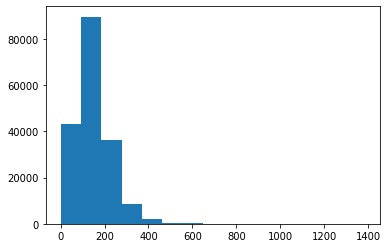

In [51]:
import matplotlib.pyplot as plt
plt.hist(char_lens,15);

In [52]:
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [53]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [54]:
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [58]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = 'char_vectorizer')

In [59]:
char_vectorizer.adapt(train_chars)

In [60]:
char_vocab = char_vectorizer.get_vocabulary()

In [61]:
char_vocab[:5]

['', '[UNK]', 'e', 't', 'i']

In [62]:
char_vocab[-5:]

['k', 'x', 'z', 'q', 'j']

In [70]:
random_train_chars = random.choice(train_chars)

print(f'Charified text:\n{random_train_chars}')
print(f'Lenght of charified text: {len(random_train_chars)}')

chartified_text = char_vectorizer([random_train_chars])
print(f'Vectorized first char:\n{chartified_text[0]}')

Charified text:
t h e   f i n d i n g s   s u g g e s t   t h a t   f u r t h e r   i n v e s t i g a t i o n   i s   w a r r a n t e d   .
Lenght of charified text: 123
Vectorized first char:
[ 3 13  2 17  4  6 10  4  6 18  9  9 16 18 18  2  9  3  3 13  5  3 17 16
  8  3 13  2  8  4  6 21  2  9  3  4 18  5  3  4  7  6  4  9 20  5  8  8
  5  6  3  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 

In [69]:
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero=True,
                              name = 'char_embed')

In [72]:
print(f'Charified text:\n{random_train_chars}\n')
char_embeded_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars:\n{char_embeded_example}')
print(f'Character embedding shape: {char_embeded_example.shape}')

Charified text:
t h e   f i n d i n g s   s u g g e s t   t h a t   f u r t h e r   i n v e s t i g a t i o n   i s   w a r r a n t e d   .

Embedded chars:
[[[ 0.02828648 -0.03806893 -0.04362784 ...  0.01759132 -0.01029086
    0.04302838]
  [ 0.02078826  0.03295093 -0.03970295 ...  0.01756697  0.04934664
    0.00509918]
  [-0.01989034 -0.01765104 -0.03386605 ...  0.04303903  0.03006269
   -0.00284394]
  ...
  [ 0.03032055  0.01833094  0.02266288 ... -0.00484079  0.01693758
    0.03421117]
  [ 0.03032055  0.01833094  0.02266288 ... -0.00484079  0.01693758
    0.03421117]
  [ 0.03032055  0.01833094  0.02266288 ... -0.00484079  0.01693758
    0.03421117]]]
Character embedding shape: (1, 290, 25)
